In [12]:
from __future__ import division
import keras
import os
import sys
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import pickle
import pandas as pd

from scipy.io import loadmat
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from tensorflow.python.keras import backend
from tensorflow.keras.models import load_model

from keras import optimizers
from keras import initializers
from keras.models import load_model
from keras.models import Sequential
from keras.layers import GRU, RNN, LSTM, Reshape, SimpleRNN, Conv2D, MaxPooling2D, Permute, Flatten, Dense, BatchNormalization, Activation, Dropout

In [13]:
def slice_data(X, V, y, window_size, nr_epochs,step_size):

    sX = [X[:,i*step_size:i*step_size+window_size,:] for i in range(nr_epochs)]
    sV = [V[i*step_size,:] for i in range(nr_epochs)]
    
    sV = np.array(sV)
    sX = np.array(sX)
    sX = np.transpose(sX,(1,2,3,0))
    
    validation = np.zeros((y.shape[0],sV.shape[0]))
    for i in range(y.shape[0]):
        letter_index = y[i,0]-1
        validation[i,:] = sV[:,letter_index] 

    return sX, sV, validation

In [14]:
def transpose_reshape(X,y):
    x_channel, x_window, x_trial, x_epoch = X.shape
    
    X = X.transpose(2,3,1,0)
    X = X.reshape(x_epoch * x_trial, x_window, x_channel, 1)

    y.transpose(1,0)
    y = y.reshape(x_trial * x_epoch)
    
    return X, y

In [15]:
def one_hot_encode(y):
    # One-Hot encoding of a flat validation array
    hot_vector = np.zeros((y.shape[0],2))
    for i in range(y.shape[0]):
        if y[i] == 1:
            hot_vector[i,1] = 1
        else:
            hot_vector[i,0] = 1
            
    return hot_vector   

In [16]:
def load_donders_matfile(par = 1):
    data = loadmat('Data/xsub-{:02d}/xsub-{:02d}_gdf.mat'.format(par,par))
    X = data['X']           # EEG data: channels x samples x trials
    V = data['V']           # Codes: bits x codes
    y = data['y']           # Labels: 1 x trials
    
    
    channels = ['Fpz','T7', 'O1', 'POz', 'Oz', 'Iz', 'O2', 'T8']

#     print('X: ',X.shape)
#     print('V: ',V.shape)
#     print('y: ',y.shape)

    n_channels, n_samples, n_trials = X.shape   # Extracting data dimensions
    step_size = 2                               # from 8ms per sample to 16 ms per sample fs/fr
    window_size = 30                            # Number of samples from 120 hz sampling frequency and having 250-ish ms window. 32 due to dividing by multiples of 2
    nr_epochs = int(n_samples-(n_samples/step_size)-window_size)

    
    # Extend the code to the length of the full trial.
    V_ext = np.tile(V,(15,1))

    sX, sV, validation = slice_data(X,V_ext,y,window_size,nr_epochs,step_size) 

#     print('sX: ',sX.shape)
#     print('sV: ',sV.shape)
#     print('validation: ',validation.shape)



    return sX, sV, validation, X, y


In [17]:
def split_k_folds(k_folds, sX, y, validation):
    n_trials = sX.shape[2]
    folds = np.repeat(np.arange(k_folds), n_trials / k_folds)
    
    list_fXtrain = []
    list_fXval = []
    list_fXtest = []
    

    
    list_fYtrain = []
    list_fYval = []
    list_fYtest = []
    
    list_labels = []
    
    
    for i_fold in range(k_folds):
        # Split into train and test sets
        X_train = sX[:, :, folds!=i_fold,:]
        X_test = sX[:, :, folds == i_fold,:]
        y_train = validation[folds!=i_fold,:]
        y_test = validation[folds == i_fold,:]
        
        test_labels = y[folds == i_fold,:]
        
        
        # Split test in to a dedicated validation set and testing set
        val_test_split = int(X_test.shape[2] / 2)
        test_labels = test_labels[val_test_split:,:]
        
        # Reshape all sets to the NHWC format (samples x windowSize x channels x 1) for the network
        fXtrain, fYtrain = transpose_reshape(X_train, y_train)
        fXval, fYval = transpose_reshape(X_test[:,:,:val_test_split,:], y_test[:val_test_split,:])
        fXtest, fYtest = transpose_reshape(X_test[:,:,val_test_split:,:], y_test[val_test_split:,:])
        
        
        # One-hot encode every y for the network
        fYtrain = one_hot_encode(fYtrain)
        fYval = one_hot_encode(fYval)
        fYtest = one_hot_encode(fYtest)
        
        
        # Add every fold set to their corresponding list
        list_fXtrain.append(fXtrain)
        list_fXval.append(fXval)
        list_fXtest.append(fXtest)

        list_fYtrain.append(fYtrain)
        list_fYval.append(fYval)
        list_fYtest.append(fYtest)
        
        list_labels.append(test_labels)
        
    return list_fXtrain, list_fXval, list_fXtest, list_fYtrain, list_fYval, list_fYtest, list_labels



(8, 30, 186000) (186000,)


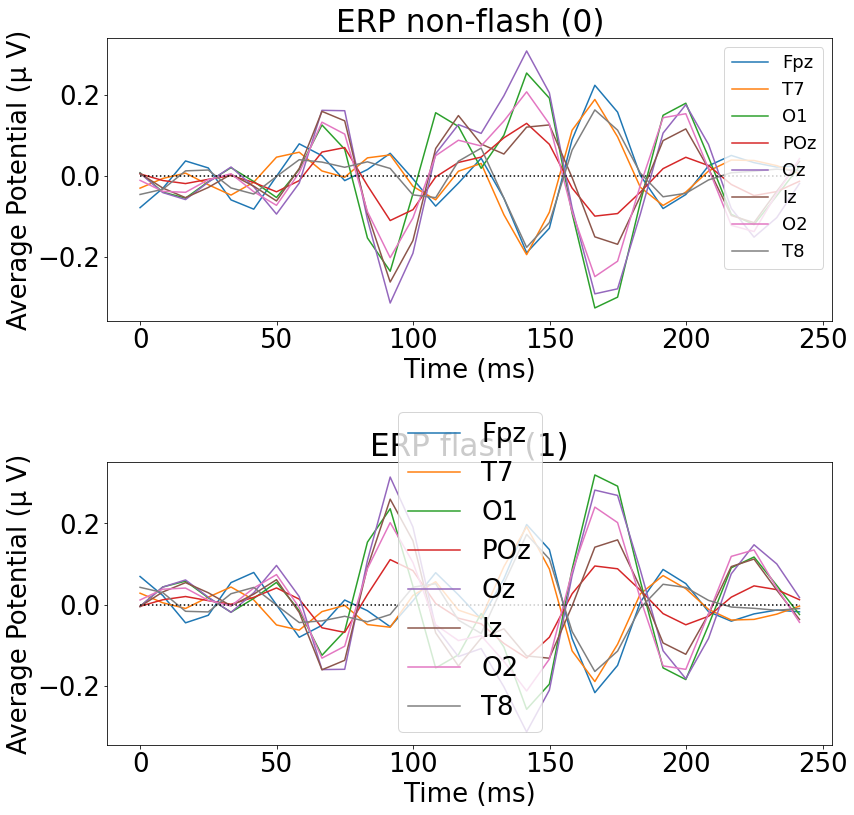

In [18]:
sX,sV,validation,_,_ = load_donders_matfile(2)

sX_ = np.reshape(sX,(sX.shape[0],sX.shape[1],-1))
labels_ = validation.flatten()
print(sX_.shape,labels_.shape)
x_axis = [i*8.33 for i in range(sX.shape[1])]
channels = ['Fpz','T7', 'O1', 'POz', 'Oz', 'Iz', 'O2', 'T8']

fig, sp = plt.subplots(2,figsize=(13,13))
plt.rcParams.update({'font.size': 26})
sp[0].plot(x_axis,np.mean(sX_[:,:,labels_==0],axis=2).T,)
sp[0].set_title('ERP non-flash (0)')
plt.rcParams.update({'font.size': 18})
sp[0].legend(channels)
plt.rcParams.update({'font.size': 26})
sp[0].plot(x_axis, [0 for i in range(len(x_axis))],'k:')
sp[0].set_xlabel('Time (ms)')
sp[0].set_ylabel('Average Potential (\u03BC V)')



sp[1].plot(x_axis,np.mean(sX_[:,:,labels_==1],axis=2).T)
sp[1].set_title('ERP flash (1)')
sp[1].legend(channels)
sp[1].plot(x_axis, [0 for i in range(len(x_axis))],'k:')
sp[1].set_xlabel('Time (ms)')
sp[1].set_ylabel('Average Potential (\u03BC V)')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

fig.savefig('erp.pdf')

In [19]:
def load_models(participants, n_folds):
    models_participants = []
    for par in range(1,amount_participants+1):
        models = []
        for fold in range(n_folds):
            MODEL_FILE = 'basic_trained_par_{:d}_fold_{:d}.hdf5'.format(par, fold)
            model = load_model(MODEL_FILE)
            models.append(model)
        models_participants.append(models)

    models_participants = np.array(models_participants)
    
    return models_participants

In [20]:
def load_RNN_models(participants):
    RNN_models = []
    for par in range(1,amount_participants+1):
        MODEL_FILE = 'RNN_trained_par_{:d}.hdf5'.format(par)
        model = load_model(MODEL_FILE)

    RNN_models = np.array(model)
    
    return RNN_models

## LDA scores

In [21]:
# LDA + Epoch classification

def crossval_LDA(par, fold, sV, data_x_train, data_x_test, data_y_train, data_y_test, labels):
    
    # Define shapes (samples x windows x channels x single (1) )
    s_train, w_train, c_train, s = data_x_train.shape
    s_test, w_test, c_test, s = data_x_test.shape

    Xtrain = data_x_train.reshape(s_train, w_train*c_train*s)
    Ytrain = data_y_train[:,1]

    Xtest = data_x_test.reshape(s_test, w_test*c_test*s) 
    Ytest = data_y_test[:,1]

    
    # Classify epochs
    clf = LDA()
    clf.fit(Xtrain, Ytrain)
    score = clf.score(Xtest, Ytest)
    print('LDA participant {:d}, fold {:d}: epoch accuracy: {:.2f}%'.format(par, fold, score*100))
    
    
    # Classify trials
    trials = 10
    epochs = int(Xtest.shape[0]/trials)
    
    # Predict Xtrain epochs. Take column 1 since that equals probabilities of 1 occuring
    pred_proba = clf.predict_proba(Xtest)
    p1 = pred_proba[:,1]


    
    
    # Reshape predictions to trials x epochs
    predicted_trials = p1.reshape(trials,epochs)

    
    #First index of labels for the test set
    test_trials = 90

    
    predictions = np.zeros(trials)
    for i in range(trials):
        rho = np.corrcoef(predicted_trials[i,:],sV.T)[0, 1:]
        predictions[i]=np.argmax(rho)+1

    pp = sum(predictions == labels[:,0])
    trial_score = pp/trials
    print('LDA participant {:d}, fold {:d}: trial accuracy: {:.2f}%'.format(par, fold, trial_score*100))
    
    print('Predicted trials: ', predictions.astype(int))
    print('True trials:      ', labels[:,0], '\n')
    
    return score, trial_score

## NN scores

In [22]:
# NN epoch + trial classification

def crossval_NN(par, fold, model, batch_size, sV, Xtrain, Xtest, Ytrain, Ytest, labels):
    
    predict_proba_test = model.predict(Xtest, batch_size = batch_size)
    true_epochs = Ytest[:,1]
    pred_epochs = predict_proba_test[:,1]
    
    # Epoch classification
    correct = 0
    for i in range(true_epochs.shape[0]):
        if (pred_epochs[i] >= 0.5) and (true_epochs[i]==1):
            correct+=1
        if (pred_epochs[i] < 0.5) and (true_epochs[i]==0):
            correct+=1
    
    score = correct / true_epochs.shape[0]
    print('NN participant {:d}, fold {:d}: epoch accuracy: {:.2f}%'.format(par, fold, score*100))
    
    
    # Trial classification
    trials = 10
    epochs = int(Xtest.shape[0]/trials)

    predicted_trials = pred_epochs.reshape(trials,epochs)



    # Use correlation to match predicted pattern to specific label
    predictions = np.zeros(trials)
    for i in range(trials):
        rho = np.corrcoef(predicted_trials[i,:],sV.T)[0, 1:]
        predictions[i]=np.argmax(rho)+1

    pp = sum(predictions == labels[:,0])
    trial_score = pp/trials
    
    print('NN participant {:d}, fold {:d}: trial accuracy: {:.2f}%'.format(par, fold, trial_score*100))   
    print('Predicted trials: ', predictions.astype(int))
    print('True trials:      ', labels[:,0], '\n')
    
    
    return score, trial_score
    


## RNN scores

In [23]:
# NN epoch + trial classification

def crossval_RNN(par, model, batch_size, sV, Xtrain, Xtest, Ytrain, Ytest, labels):
    
    predict_proba_test = model.predict(Xtest, batch_size = batch_size)
    true_epochs = Ytest[:,1]
    pred_epochs = predict_proba_test[:,1]
    
    # Epoch classification
    correct = 0
    for i in range(true_epochs.shape[0]):
        if (pred_epochs[i] >= 0.5) and (true_epochs[i]==1):
            correct+=1
        if (pred_epochs[i] < 0.5) and (true_epochs[i]==0):
            correct+=1
    
    score = correct / true_epochs.shape[0]
    print('RNN participant {:d}: epoch accuracy: {:.2f}%'.format(par, score*100))
    
    
    # Trial classification
    trials = 10
    epochs = int(Xtest.shape[0]/trials)

    predicted_trials = pred_epochs.reshape(trials,epochs)



    # Use correlation to match predicted pattern to specific label
    predictions = np.zeros(trials)
    for i in range(trials):
        rho = np.corrcoef(predicted_trials[i,:],sV.T)[0, 1:]
        predictions[i]=np.argmax(rho)+1

    pp = sum(predictions == labels[:,0])
    trial_score = pp/trials
    
    print('RNN participant {:d}: trial accuracy: {:.2f}%'.format(par, trial_score*100))   
    print('Predicted trials: ', predictions.astype(int))
    print('True trials:      ', labels[:,0], '\n')
    
    
    return score, trial_score
    


In [ ]:
amount_participants = 20
n_folds = 5
batch_size = 1860


# Gather the data
data_participants = []

LDA_scores = []
LDA_trial_scores = []

NN_scores = []
NN_trial_scores = []

RNN_scores = []
RNN_trial_scores = []



for par in range (1,amount_participants+1):
    
    
    LDA_par_score = []
    LDA_par_trial_score = []
    
    NN_par_score = []
    NN_par_trial_score = []
    
    
    # Load trained RNN model
    RNN_MODEL_FILE = 'RNN_trained_par_{:d}.hdf5'.format(par)
    RNN_model = load_model(RNN_MODEL_FILE, compile=False)
    
    for fold in range(n_folds):
        
        # Load fold data
        sX,sV,validation,X,y = load_donders_matfile(par)
        list_fXtrain, list_fXval, list_fXtest, list_fYtrain, list_fYval, list_fYtest, list_labels = split_k_folds(n_folds, sX, y, validation)
        
        # Load trained NN model
        MODEL_FILE = 'basic_trained_par_{:d}_fold_{:d}.hdf5'.format(par, fold)
        model = load_model(MODEL_FILE)
        
        
        LDA_score, LDA_trial_score = crossval_LDA(par, fold, sV, 
                                                  list_fXtrain[fold], 
                                                  list_fXtest[fold], 
                                                  list_fYtrain[fold], 
                                                  list_fYtest[fold], 
                                                  list_labels[fold]
                                                 )

        NN_score, NN_trial_score = crossval_NN(par, fold, model, batch_size, sV, 
                                               list_fXtrain[fold], 
                                               list_fXtest[fold], 
                                               list_fYtrain[fold], 
                                               list_fYtest[fold], 
                                               list_labels[fold]
                                              )
        
        
        LDA_par_score.append(LDA_score)
        LDA_par_trial_score.append(LDA_trial_score)
        
        NN_par_score.append(NN_score)
        NN_par_trial_score.append(NN_trial_score)
        
    
    
    RNN_score, RNN_trial_score = crossval_RNN(par, RNN_model, batch_size, sV, 
                                               list_fXtrain[fold], 
                                               list_fXtest[fold], 
                                               list_fYtrain[fold], 
                                               list_fYtest[fold], 
                                               list_labels[fold]
                                              )
    
    LDA_scores.append(LDA_par_score)
    LDA_trial_scores.append(LDA_par_trial_score)

    NN_scores.append(NN_par_score)
    NN_trial_scores.append(NN_par_trial_score)

    RNN_scores.append(RNN_score) 
    RNN_trial_scores.append(RNN_trial_score)
    





LDA participant 1, fold 0: epoch accuracy: 70.94%
LDA participant 1, fold 0: trial accuracy: 100.00%
Predicted trials:  [ 6 13 20  4 12 16 14 15  2  1]
True trials:       [ 6 13 20  4 12 16 14 15  2  1] 

NN participant 1, fold 0: epoch accuracy: 79.33%
NN participant 1, fold 0: trial accuracy: 100.00%
Predicted trials:  [ 6 13 20  4 12 16 14 15  2  1]
True trials:       [ 6 13 20  4 12 16 14 15  2  1] 

LDA participant 1, fold 1: epoch accuracy: 70.92%
LDA participant 1, fold 1: trial accuracy: 90.00%
Predicted trials:  [ 1 11  6 15  4  7 14 12 11  2]
True trials:       [ 1 11  6 15  4  7 14 12 19  2] 

NN participant 1, fold 1: epoch accuracy: 78.52%
NN participant 1, fold 1: trial accuracy: 90.00%
Predicted trials:  [ 1 11  6 15  4  7 14 12  8  2]
True trials:       [ 1 11  6 15  4  7 14 12 19  2] 

LDA participant 1, fold 2: epoch accuracy: 69.62%
LDA participant 1, fold 2: trial accuracy: 90.00%
Predicted trials:  [16 10  7  8 19  9 12 13 20 11]
True trials:       [16 10  7  8 19 

LDA participant 4, fold 4: epoch accuracy: 62.80%
LDA participant 4, fold 4: trial accuracy: 100.00%
Predicted trials:  [ 8 15  7 11 16  9 10 19 18 20]
True trials:       [ 8 15  7 11 16  9 10 19 18 20] 

NN participant 4, fold 4: epoch accuracy: 64.48%
NN participant 4, fold 4: trial accuracy: 100.00%
Predicted trials:  [ 8 15  7 11 16  9 10 19 18 20]
True trials:       [ 8 15  7 11 16  9 10 19 18 20] 

RNN participant 4: epoch accuracy: 59.44%
RNN participant 4: trial accuracy: 90.00%
Predicted trials:  [ 8 15  7 11 16  9 10 19 18 16]
True trials:       [ 8 15  7 11 16  9 10 19 18 20] 

LDA participant 5, fold 0: epoch accuracy: 64.32%
LDA participant 5, fold 0: trial accuracy: 100.00%
Predicted trials:  [15  8 20 16  1  2 14 11 13 19]
True trials:       [15  8 20 16  1  2 14 11 13 19] 

NN participant 5, fold 0: epoch accuracy: 63.16%
NN participant 5, fold 0: trial accuracy: 100.00%
Predicted trials:  [15  8 20 16  1  2 14 11 13 19]
True trials:       [15  8 20 16  1  2 14 11 13 19

NN participant 8, fold 2: epoch accuracy: 64.06%
NN participant 8, fold 2: trial accuracy: 100.00%
Predicted trials:  [ 6 17 13  8 20 12  2 15 14  1]
True trials:       [ 6 17 13  8 20 12  2 15 14  1] 

LDA participant 8, fold 3: epoch accuracy: 66.63%
LDA participant 8, fold 3: trial accuracy: 100.00%
Predicted trials:  [ 2 11  8  6 12  5  4 15 20 10]
True trials:       [ 2 11  8  6 12  5  4 15 20 10] 

NN participant 8, fold 3: epoch accuracy: 70.03%
NN participant 8, fold 3: trial accuracy: 100.00%
Predicted trials:  [ 2 11  8  6 12  5  4 15 20 10]
True trials:       [ 2 11  8  6 12  5  4 15 20 10] 

LDA participant 8, fold 4: epoch accuracy: 63.20%
LDA participant 8, fold 4: trial accuracy: 100.00%
Predicted trials:  [18  9 12 20 11  8 19  4  6 15]
True trials:       [18  9 12 20 11  8 19  4  6 15] 

NN participant 8, fold 4: epoch accuracy: 63.79%
NN participant 8, fold 4: trial accuracy: 100.00%
Predicted trials:  [18  9 12 20 11  8 19  4  6 15]
True trials:       [18  9 12 20 11

LDA participant 12, fold 1: epoch accuracy: 52.31%
LDA participant 12, fold 1: trial accuracy: 10.00%
Predicted trials:  [7 3 8 8 8 8 8 8 3 8]
True trials:       [ 6  2  9  1 16 15 20  4  3 12] 

NN participant 12, fold 1: epoch accuracy: 52.56%
NN participant 12, fold 1: trial accuracy: 10.00%
Predicted trials:  [ 7 18  8 17  8  8  8  8  3  8]
True trials:       [ 6  2  9  1 16 15 20  4  3 12] 

LDA participant 12, fold 2: epoch accuracy: 52.27%
LDA participant 12, fold 2: trial accuracy: 30.00%
Predicted trials:  [ 3  7 13  8 17 11  7  4  8 11]
True trials:       [ 3  2 13 16 15  1 10  4  9 20] 

NN participant 12, fold 2: epoch accuracy: 53.12%
NN participant 12, fold 2: trial accuracy: 20.00%
Predicted trials:  [3 3 8 8 8 8 8 4 8 6]
True trials:       [ 3  2 13 16 15  1 10  4  9 20] 

LDA participant 12, fold 3: epoch accuracy: 63.77%
LDA participant 12, fold 3: trial accuracy: 90.00%
Predicted trials:  [12 20  7 16  1 12 15  8 13  4]
True trials:       [12 20  7 16  1  9 15  8 13 

RNN participant 15: epoch accuracy: 61.66%
RNN participant 15: trial accuracy: 90.00%
Predicted trials:  [16 10 19  8 11 18 16  2  4  6]
True trials:       [15 10 19  8 11 18 16  2  4  6] 

LDA participant 16, fold 0: epoch accuracy: 60.87%
LDA participant 16, fold 0: trial accuracy: 100.00%
Predicted trials:  [15  8 20 16  1  2 14 11 13 19]
True trials:       [15  8 20 16  1  2 14 11 13 19] 

NN participant 16, fold 0: epoch accuracy: 65.56%
NN participant 16, fold 0: trial accuracy: 100.00%
Predicted trials:  [15  8 20 16  1  2 14 11 13 19]
True trials:       [15  8 20 16  1  2 14 11 13 19] 

LDA participant 16, fold 1: epoch accuracy: 61.99%
LDA participant 16, fold 1: trial accuracy: 90.00%
Predicted trials:  [ 6  2  9  1 16 15 20  4 16 12]
True trials:       [ 6  2  9  1 16 15 20  4  3 12] 

NN participant 16, fold 1: epoch accuracy: 66.10%
NN participant 16, fold 1: trial accuracy: 90.00%
Predicted trials:  [ 6  2  9  1 16 15 20  4 12 12]
True trials:       [ 6  2  9  1 16 15 20 

## Statistical analysis

In [183]:
def avg(list):
    return sum(list)/len(list)

In [222]:
#LDA_scores
#LDA_trial_scores

#NN_scores
#NN_trial_scores

#RNN_scores
#RNN_trial_scores

LDA_avg = []
NN_avg = []

LDA_trial_avg = []
NN_trial_avg = []

for i in range(amount_participants):
    LDA_avg.append(avg(LDA_scores[i]))
    NN_avg.append(avg(NN_scores[i]))
    
    LDA_trial_avg.append(avg(LDA_trial_scores[i]))
    NN_trial_avg.append(avg(NN_trial_scores[i]))


# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('pdf', 'svg')

from scipy.stats import wilcoxon
from scipy.stats import tstd
from scipy.stats import normaltest
import random
from statsmodels.sandbox.stats.multicomp import multipletests


MODEL_FILE = 'basic_trained_par_1_fold_1.hdf5'
model = load_model(MODEL_FILE)
data_x_test = list_fXtest[0]
t = model.predict(data_x_test, batch_size = batch_size)
test = normaltest(t[:,1])
print(t[:,1])
print('test', test[1])

# Compare LDA - NN
w, p_LDA_NN = wilcoxon(LDA_avg, NN_avg, alternative = 'less')
w, p_LDA_NN_trial = wilcoxon(LDA_trial_avg, NN_trial_avg, alternative = 'less')


# Compare LDA - RNN
w, p_LDA_RNN = wilcoxon(LDA_avg, RNN_scores, alternative = 'less')
w, p_LDA_RNN_trial = wilcoxon(LDA_trial_avg, RNN_trial_scores, alternative = 'less')


# Compare NN - RNN
w, p_NN_RNN = wilcoxon(NN_avg, RNN_scores, alternative = 'less')
w, p_NN_RNN_trial = wilcoxon(NN_trial_avg, RNN_trial_scores, alternative = 'less')


# Compare NN - LDA
w, p_NN_LDA = wilcoxon(NN_avg, LDA_avg, alternative = 'less')
w, p_NN_LDA_trial = wilcoxon(NN_trial_avg, LDA_trial_avg, alternative = 'less')


# Compare RNN - LDA
w, p_RNN_LDA = wilcoxon(RNN_scores, LDA_avg, alternative = 'less')
w, p_RNN_LDA_trial = wilcoxon(RNN_trial_scores, LDA_trial_avg, alternative = 'less')


# Compare RNN - NN
w, p_RNN_NN = wilcoxon(RNN_scores, NN_avg, alternative = 'less')
w, p_RNN_NN_trial = wilcoxon(RNN_trial_scores, NN_trial_avg, alternative = 'less')

print('p-value LDA-NN: ' , p_LDA_NN)
print('p-value LDA-NN trials: ', p_LDA_NN_trial)

print('p-value LDA-RNN: ' , p_LDA_RNN)
print('p-value LDA-RNN trials: ', p_LDA_RNN_trial)

print('p-value NN-RNN: ' , p_NN_RNN)
print('p-value NN-RNN trials: ', p_NN_RNN_trial)


print('p-value NN-LDA: ' , p_NN_LDA)
print('p-value NN-LDA trials: ', p_NN_LDA_trial)

print('p-value RNN-LDA: ' , p_RNN_LDA)
print('p-value RNN-LDA trials: ', p_RNN_LDA_trial)

print('p-value RNN-NN: ' , p_RNN_NN)
print('p-value RNN-NN trials: ', p_RNN_NN_trial)

p = [p_LDA_NN, p_LDA_RNN, p_NN_RNN, p_NN_LDA, p_RNN_LDA, p_RNN_NN, p_LDA_NN_trial, p_LDA_RNN_trial, p_NN_RNN_trial, p_NN_LDA_trial, p_RNN_LDA_trial, p_RNN_NN_trial]
p_trial = [p_LDA_NN_trial, p_LDA_RNN_trial, p_NN_RNN_trial, p_NN_LDA_trial, p_RNN_LDA_trial, p_RNN_NN_trial]

p_adjusted = multipletests(p, method='bonferroni')
# p_trial_adjusted = multipletests(p_trial, method='bonferroni')

print(p_adjusted)
print(p_trial_adjusted)

LDA_var = tstd(LDA_avg)
NN_var = tstd(NN_avg)
RNN_var = tstd(RNN_scores)

LDA_trial_var = tstd(LDA_trial_avg)
NN_trial_var = tstd(NN_trial_avg)
RNN_trial_var = tstd(RNN_trial_scores)

# tot_avg_LDA = sum(LDA_scores)/len(NN_scores)
# tot_avg_NN = sum(NN_scores)/len(NN_scores)
# tot_avg_LDA_trial = sum(LDA_trial_scores)/len(NN_trial_scores)
# tot_avg_NN_trial = sum(NN_trial_scores)/len(NN_trial_scores)

y1 = [LDA_avg, NN_avg, RNN_scores]
y2 = [LDA_trial_avg, NN_trial_avg, RNN_trial_scores]



# print('epoch difference p-value: ',p1)

# print('trial difference p-value: ',p2)



print('avg LDA epoch', avg(LDA_avg))
print('avg CNN epoch ', avg(NN_avg))
print('avg RNN epoch ', avg(RNN_scores))

print('avg LDA trial', avg(LDA_trial_avg))
print('avg CNN trial ', avg(NN_trial_avg))
print('avg RNN trial ', avg(RNN_trial_scores))


[0.26081678 0.16572742 0.7357292  ... 0.19730316 0.68697983 0.47290698]
test 0.0
p-value LDA-NN:  0.0011625289916992188
p-value LDA-NN trials:  0.028023386503852714
p-value LDA-RNN:  0.9994916915893555
p-value LDA-RNN trials:  0.9384536743164062
p-value NN-RNN:  0.9999589920043945
p-value NN-RNN trials:  0.9620742797851562
p-value NN-LDA:  0.9990072250366211
p-value NN-LDA trials:  0.9719766134961473
p-value RNN-LDA:  0.0006046295166015625
p-value RNN-LDA trials:  0.06154632568359375
p-value RNN-NN:  5.245208740234375e-05
p-value RNN-NN trials:  0.03792572021484375
(array([ True, False, False, False,  True,  True, False, False, False,
       False, False, False]), array([1.39503479e-02, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       7.25555420e-03, 6.29425049e-04, 3.36280638e-01, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 7.38555908e-01, 4.55108643e-01]), 0.004265318777560645, 0.004166666666666667)
(array([False, False, False]), array([0.08407016, 1.        , 1.    

C:\Users\David\Anaconda 3\envs\py_keras_38\lib\site-packages\scipy\stats\morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [169]:
r1 =[i/10000 for i in random.sample(range(-3000, 3000), len(y1[0]))]
r2 =[i/10000 for i in random.sample(range(7000, 13000), len(y1[0]))]
r3 =[i/10000 for i in random.sample(range(17000, 23000), len(y1[0]))]

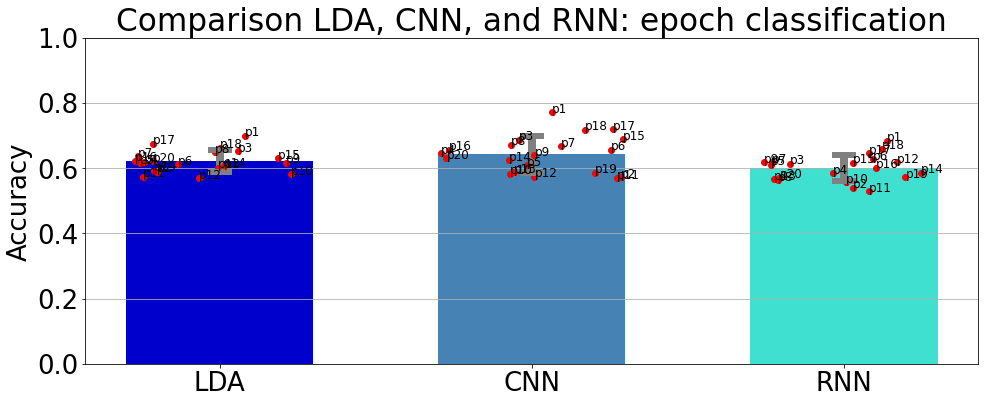

In [224]:
fig = plt.figure(num=None, figsize=(16, 6))
plt.rcParams.update({'font.size': 26})
# plt.subplot(1, 2, 1)
plt.plot()
plt.title('Comparison LDA, CNN, and RNN: epoch classification')
x1 = ['LDA', 'CNN', 'RNN']
err1 = [LDA_var, NN_var, RNN_var]
plt.bar(x1,[np.mean(y1[0]), np.mean(y1[1]), np.mean(y1[2])], 
        yerr=err1, error_kw=dict(lw=8, capsize=12, capthick=6), 
        align='center', ecolor='black', capsize=10, width = 0.6,
       color = ['mediumblue', 'steelblue', 'turquoise'])



# plt.yaxis.grid(color='gray', linestyle='dashed')
plt.grid(True, axis='y')
plt.ylim(0,1) 
plt.ylabel('Accuracy')

fig.savefig('epochs_without.pdf', bbox_inches = 'tight')

plt.scatter(r1, y1[0], color='red', zorder=2)
plt.scatter(r2, y1[1], color='red', zorder=2)
plt.scatter(r3, y1[2], color='red', zorder=2)

fig.savefig('epochs_with_scatter.pdf', bbox_inches = 'tight')


plt.rcParams.update({'font.size': 12})
for i in range(amount_participants):
    plt.annotate('p{:d}'.format(i+1), (r1[i], y1[0][i]))
    plt.annotate('p{:d}'.format(i+1), (r2[i], y1[1][i]))
    plt.annotate('p{:d}'.format(i+1), (r3[i], y1[2][i]))

plt.show()

# fig.savefig('1-vector.eps', format='eps')
fig.savefig('epochs_with.pdf', bbox_inches = 'tight')

In [226]:
fig = plt.figure(num=None, figsize=(16, 6))
plt.rcParams.update({'font.size': 26})
plt.plot()
plt.title('Comparison LDA, CNN, and RNN: trial classification')
x2 = ['LDA', 'CNN', 'RNN']
err2 = [LDA_trial_var, NN_trial_var, RNN_trial_var]
plt.bar(x2,[np.mean(y2[0]), np.mean(y2[1]), np.mean(y2[2])], 
        yerr=err2, error_kw=dict(lw=8, capsize=12, capthick=6), 
        align='center', ecolor='black', capsize=10, width = 0.6,
       color = ['mediumblue', 'steelblue', 'turquoise'])

# plt.yaxis.grid(color='gray', linestyle='dashed')
plt.grid(True, axis='y')
plt.ylim(0,1) 
plt.ylabel('Accuracy')


plt.savefig('trials_without.pdf', bbox_inches = 'tight')

plt.scatter(r1, y2[0], color='red', zorder=2)
plt.scatter(r2, y2[1], color='red', zorder=2)
plt.scatter(r3, y2[2], color='red', zorder=2)

plt.savefig('trials_with_scatter.pdf', bbox_inches = 'tight')


plt.rcParams.update({'font.size': 12})
for i in range(amount_participants):
    plt.annotate('p{:d}'.format(i+1), (r1[i], y2[0][i]))
    plt.annotate('p{:d}'.format(i+1), (r2[i], y2[1][i]))
    plt.annotate('p{:d}'.format(i+1), (r3[i], y2[2][i]))


plt.show()
fig.savefig('trials_with.pdf', bbox_inches = 'tight')

## Same figures, but only for fold 1

In [227]:
LDA_avg = []
NN_avg = []

LDA_trial_avg = []
NN_trial_avg = []

for i in range(amount_participants):
    LDA_avg.append(LDA_scores[i][0])
    NN_avg.append(NN_scores[i][0])
    
    LDA_trial_avg.append(LDA_trial_scores[i][0])
    NN_trial_avg.append(NN_trial_scores[i][0])
print(LDA_trial_avg)
print(NN_trial_avg)

LDA_var = tstd(LDA_avg)
NN_var = tstd(NN_avg)
RNN_var = tstd(RNN_scores)

LDA_trial_var = tstd(LDA_trial_avg)
NN_trial_var = tstd(NN_trial_avg)
RNN_trial_var = tstd(RNN_trial_scores)





y1 = [LDA_avg, NN_avg, RNN_scores]
y2 = [LDA_trial_avg, NN_trial_avg, RNN_trial_scores]

[1.0, 0.9, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 0.9, 0.9, 0.9, 0.2, 1.0, 1.0, 1.0, 1.0, 0.9, 0.9, 0.8, 1.0]
[1.0, 0.9, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 0.9, 0.9, 0.9, 0.2, 1.0, 1.0, 1.0, 1.0, 0.9, 0.9, 0.8, 1.0]


In [228]:
# Compare LDA - NN
w, p_LDA_NN = wilcoxon(LDA_avg, NN_avg, alternative = 'less')
# w, p_LDA_NN_trial = wilcoxon(LDA_trial_avg, NN_trial_avg, alternative = 'less')


# Compare LDA - RNN
w, p_LDA_RNN = wilcoxon(LDA_avg, RNN_scores, alternative = 'less')
w, p_LDA_RNN_trial = wilcoxon(LDA_trial_avg, RNN_trial_scores, alternative = 'less')


# Compare NN - RNN
w, p_NN_RNN = wilcoxon(NN_avg, RNN_scores, alternative = 'less')
w, p_NN_RNN_trial = wilcoxon(NN_trial_avg, RNN_trial_scores, alternative = 'less')


# Compare NN - LDA
w, p_NN_LDA = wilcoxon(NN_avg, LDA_avg, alternative = 'less')
# w, p_NN_LDA_trial = wilcoxon(NN_trial_avg, LDA_trial_avg, alternative = 'less')


# Compare RNN - LDA
w, p_RNN_LDA = wilcoxon(RNN_scores, LDA_avg, alternative = 'less')
w, p_RNN_LDA_trial = wilcoxon(RNN_trial_scores, LDA_trial_avg, alternative = 'less')


# Compare RNN - NN
w, p_RNN_NN = wilcoxon(RNN_scores, NN_avg, alternative = 'less')
w, p_RNN_NN_trial = wilcoxon(RNN_trial_scores, NN_trial_avg, alternative = 'less')

print('p-value LDA-NN: ' , p_LDA_NN)
# print('p-value LDA-NN trials: ', p_LDA_NN_trial)

print('p-value LDA-RNN: ' , p_LDA_RNN)
print('p-value LDA-RNN trials: ', p_LDA_RNN_trial)

print('p-value NN-RNN: ' , p_NN_RNN)
print('p-value NN-RNN trials: ', p_NN_RNN_trial)


print('p-value NN-LDA: ' , p_NN_LDA)
# print('p-value NN-LDA trials: ', p_NN_LDA_trial)

print('p-value RNN-LDA: ' , p_RNN_LDA)
print('p-value RNN-LDA trials: ', p_RNN_LDA_trial)

print('p-value RNN-NN: ' , p_RNN_NN)
print('p-value RNN-NN trials: ', p_RNN_NN_trial)


p = [p_LDA_NN, p_LDA_RNN, p_NN_RNN, p_NN_LDA, p_RNN_LDA, p_RNN_NN, 1, p_LDA_RNN_trial, p_NN_RNN_trial, 1, p_RNN_LDA_trial, p_RNN_NN_trial]
p_adjusted = multipletests(p, method='bonferroni')

print(p_adjusted)
print(p_trial_adjusted)

p-value LDA-NN:  0.001827239990234375
p-value LDA-RNN:  0.9986438751220703
p-value LDA-RNN trials:  0.9531414944013346
p-value NN-RNN:  0.9998025894165039
p-value NN-RNN trials:  0.9531414944013346
p-value NN-LDA:  0.9984235763549805
p-value RNN-LDA:  0.0015764236450195312
p-value RNN-LDA trials:  0.046858505598665445
p-value RNN-NN:  0.00024127960205078125
p-value RNN-NN trials:  0.046858505598665445
(array([ True, False, False, False,  True,  True, False, False, False,
       False, False, False]), array([0.02192688, 1.        , 1.        , 1.        , 0.01891708,
       0.00289536, 1.        , 1.        , 1.        , 1.        ,
       0.56230207, 0.56230207]), 0.004265318777560645, 0.004166666666666667)
(array([False, False, False]), array([0.08407016, 1.        , 1.        ]), 0.016952427508441503, 0.016666666666666666)


C:\Users\David\Anaconda 3\envs\py_keras_38\lib\site-packages\scipy\stats\morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [230]:
fig = plt.figure(num=None, figsize=(16, 6))
plt.rcParams.update({'font.size': 26})
# plt.subplot(1, 2, 1)
plt.plot()
plt.title('Single fold comparison LDA, CNN, and RNN:\n epoch classification')
x1 = ['LDA', 'CNN', 'RNN']
err1 = [LDA_var, NN_var, RNN_var]
plt.bar(x1,[np.mean(y1[0]), np.mean(y1[1]), np.mean(y1[2])], 
        yerr=err1, error_kw=dict(lw=8, capsize=12, capthick=6), 
        align='center', ecolor='black', capsize=10, width = 0.6,
        color = ['mediumblue', 'steelblue', 'turquoise'])

# plt.yaxis.grid(color='gray', linestyle='dashed')
plt.grid(True, axis='y')
plt.ylim(0,1) 
plt.ylabel('Accuracy')

fig.savefig('SF_epochs_without.pdf', bbox_inches = 'tight')

plt.scatter(r1, y1[0], color='red', zorder=2)
plt.scatter(r2, y1[1], color='red', zorder=2)
plt.scatter(r3, y1[2], color='red', zorder=2)

fig.savefig('SF_epochs_with_scatter.pdf', bbox_inches = 'tight')


plt.rcParams.update({'font.size': 12})
for i in range(amount_participants):
    plt.annotate('p{:d}'.format(i+1), (r1[i], y1[0][i]))
    plt.annotate('p{:d}'.format(i+1), (r2[i], y1[1][i]))
    plt.annotate('p{:d}'.format(i+1), (r3[i], y1[2][i]))

plt.show()

# fig.savefig('1-vector.eps', format='eps')
fig.savefig('SF_epochs_with.pdf', bbox_inches = 'tight')

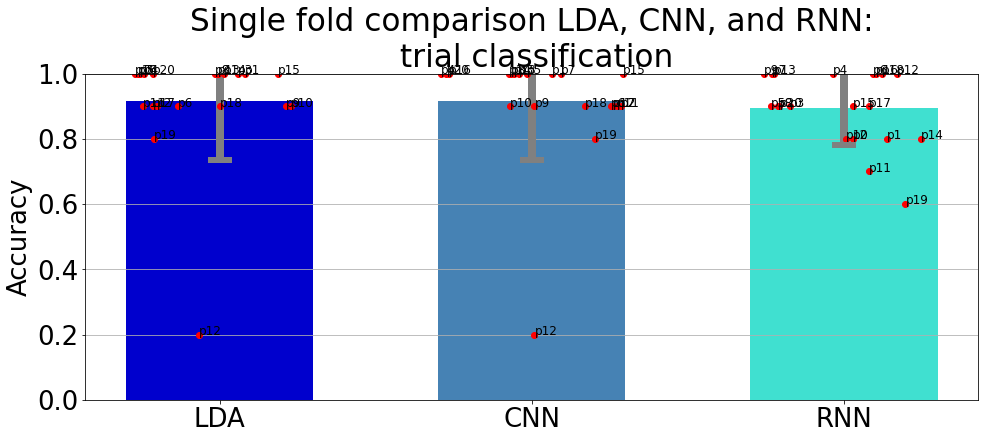

In [231]:
fig = plt.figure(num=None, figsize=(16, 6))
plt.rcParams.update({'font.size': 26})
plt.plot()
plt.title('Single fold comparison LDA, CNN, and RNN:\n trial classification')
x2 = ['LDA', 'CNN', 'RNN']
err2 = [LDA_trial_var, NN_trial_var, RNN_trial_var]
plt.bar(x2,[np.mean(y2[0]), np.mean(y2[1]), np.mean(y2[2])], 
        yerr=err2, error_kw=dict(lw=8, capsize=12, capthick=6), 
        align='center', ecolor='black', capsize=10, width = 0.6,
        color = ['mediumblue', 'steelblue', 'turquoise'])

# plt.yaxis.grid(color='gray', linestyle='dashed')
plt.grid(True, axis='y')
plt.ylim(0,1) 
plt.ylabel('Accuracy')


plt.savefig('SF_trials_without.pdf', bbox_inches = 'tight')

plt.scatter(r1, y2[0], color='red', zorder=2)
plt.scatter(r2, y2[1], color='red', zorder=2)
plt.scatter(r3, y2[2], color='red', zorder=2)

plt.savefig('SF_trials_with_scatter.pdf', bbox_inches = 'tight')


plt.rcParams.update({'font.size': 12})
for i in range(amount_participants):
    plt.annotate('p{:d}'.format(i+1), (r1[i], y2[0][i]))
    plt.annotate('p{:d}'.format(i+1), (r2[i], y2[1][i]))
    plt.annotate('p{:d}'.format(i+1), (r3[i], y2[2][i]))


plt.show()
fig.savefig('SF_trials_with.pdf', bbox_inches = 'tight')